In [1]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd
import scipy.stats as ss
from scipy.interpolate import interp1d
import pymc as pymc

import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1))

rez=600

In [2]:
#lynch=pd.read_csv('data/vrc01_lynch_dbr.csv')#,columns=['IC50','IC80','h'])


#data from catnap
antibodies=pd.read_csv('data/CATNAP/abs.txt',sep='\t')
assay=pd.read_csv('data/CATNAP/assay.txt',sep='\t')
viruses=pd.read_csv('data/CATNAP/viruses.txt',sep='\t')

antibodies[antibodies.Name=='VRC01']


,Name,Type,Structure,Donor,Clonal lineage,Isolation paper(Pubmed ID),Neutralizing antibody feature,Light chain type,# of viruses tested
227,VRC01,gp120 CD4BS,5FYJ(Clade G X1193.c1 SOSIP.664 Prefusion Env ...,NIH45,VRC01,Wu2010(20616233),Electrostatic interactions with D368;Mutation ...,K,782


In [3]:
papers=set(assay[assay['Antibody']=='VRC01']['Reference'])
print(len(papers))
print(papers)


47
{'Hoffenberg et al. J Virol 87:5372 (2013)', 'Huang et al. Immunity 45:1108 (2016a) - dataset 2', 'Huang et al. Nature 491:406 (2012a)', 'Kong et al. Immunity 44:939 (2016)', 'Zhou et al. Immunity 39:245 (2013)', 'Balla-Jhagjhoorsingh et al. PLoS One 8:e68863 (2013)', 'Doria-Rose et al. J Virol. 86:3393 (2012)', 'van Gils et al. Nat Microbiol 2:16199 (2016)', 'Goo et al. J Virol 86:10857 (2012)', 'Decamp et al. J Virol 88:2489 (2014)', 'Wu et al. Science 333:1593 (2011)', 'McCoy et al. J Exp Med. 209:1091 (2012)', 'Crooks et al. PLoS Pathog 11:e1004932 (2015)', 'Gardner et al. J Virol 90:7822 (2016)', 'McLellan et al. Nature 480:336 (2011)', 'Rusert et al. Nat Med 22:1260 (2016)', 'Bonsignori et al. Cell 165:449 (2016)', 'Sok et al. Immunity 45:31 (2016)', 'Doria-Rose et al. Nature 509:55 (2014)', 'Wagh et al. PLoS Pathog 12:e1005520 (2016)', 'Georgiev et al. Science 340:751 (2013) - dataset 1', 'Georgiev et al. Science 340:751 (2013) - dataset 4', 'Chuang et al. J Virol. 87:10047 (

In [4]:
#collect all individual data
yunda=pd.read_csv('data/yunda_dbr.csv')
cohort_names=['10mg/kg','30mg/kg']

dd=[[],[]]; tt=[[],[]]

#loop over the two groups we are interested in
grp_ind=0
for i_grp in [4,5]:        
    grp=yunda[yunda.group==i_grp]
    #loop over the participant IDs
    print('cohort',i_grp,'contains',len(np.unique(grp['ID'])),'participants')
    for i_id in np.unique(grp['ID']):
        ppt=grp[grp['ID']==i_id]
        #loop over ppt different doses
        for i_occ in np.unique(ppt['occ']):
            pk=ppt[ppt['occ']==i_occ]
            tt[grp_ind].append(np.array(pk.TIME))
            dd[grp_ind].append(np.append(np.array(pk.AMT.dropna()),np.array(pk.DV.dropna()))); #factor in the DV and AMT weirdness

    grp_ind+=1


cohort 4 contains 12 participants
cohort 5 contains 12 participants


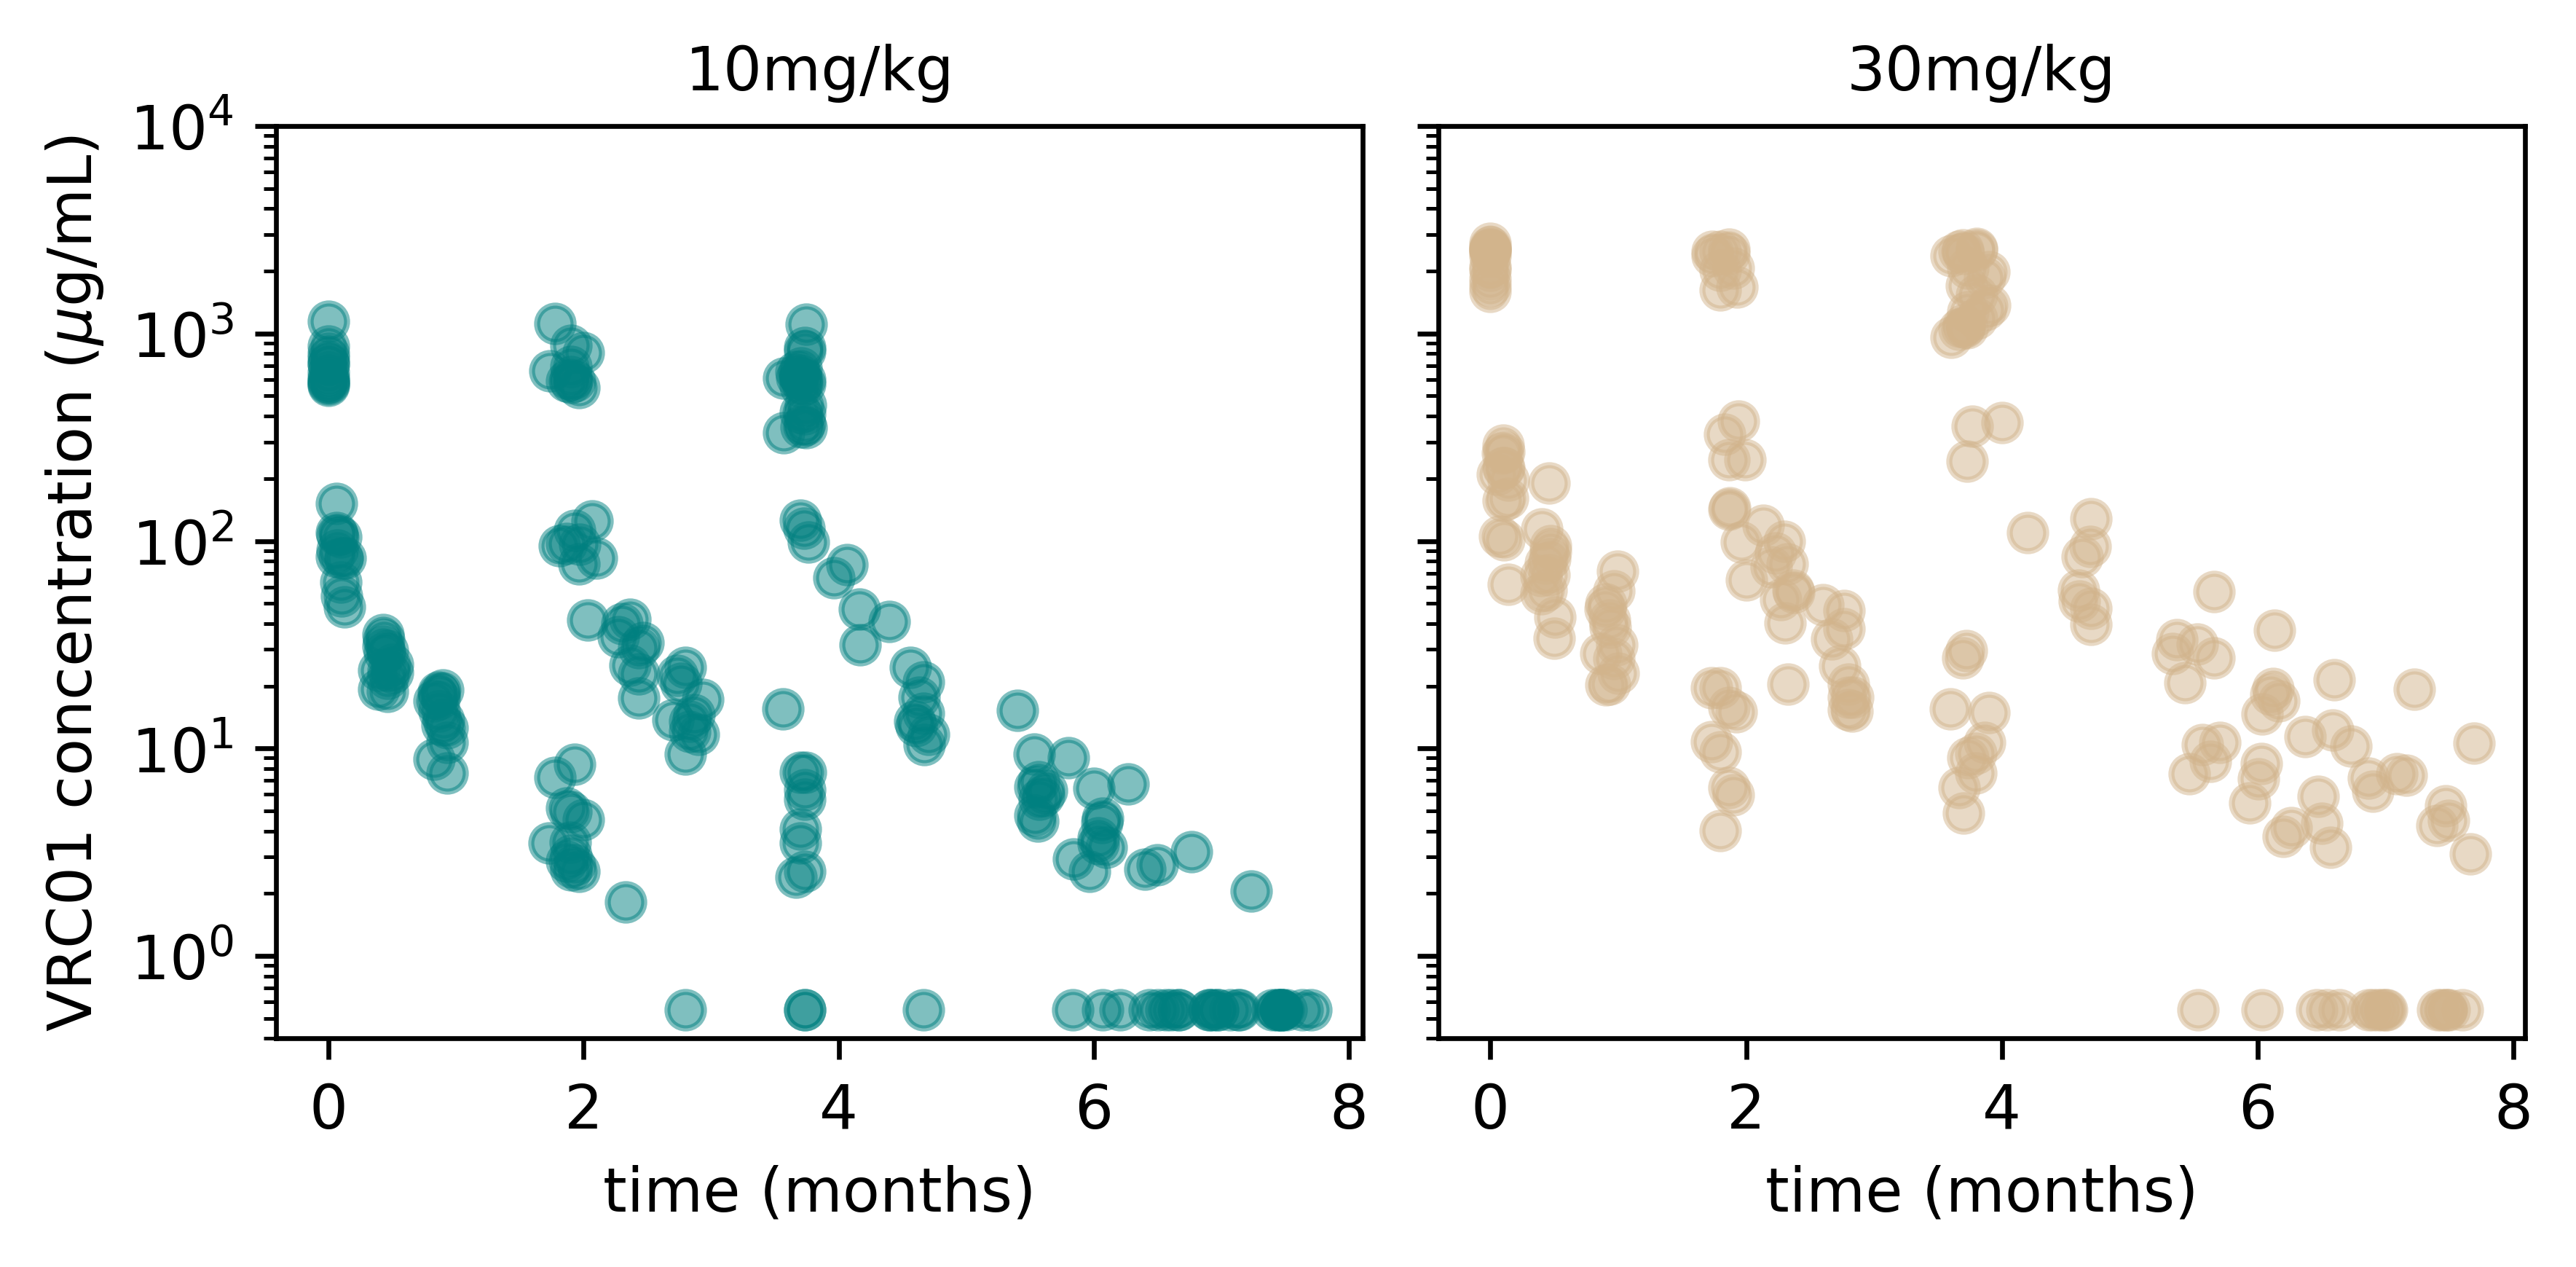

In [5]:
#plot all the patient data by cohort
fig,axarr=plt.subplots(1,2,sharey=True,figsize=(6,3),dpi=rez)

c_list=['teal','tan']; var=[]
for i in range(len(cohort_names)):        
    ax=axarr[i]
    for j in range(len(tt[i])):
        ax.scatter(np.array(tt[i][j])/30,dd[i][j],alpha=0.5,color=c_list[i])
    
    ax.set_title(cohort_names[i],fontsize=10)
    ax.set_yscale('log')
    ax.set_ylim([0.4,1e4])
    ax.set_xlabel('time (months)')
                    
axarr[0].set_ylabel('VRC01 concentration ($\mu$g/mL)')
fig.tight_layout()
fig.savefig('figures/PKraw.pdf')

In [6]:
#functino to fit individual level data
def bi_exp_fit(t,A1,k1,A2,k2):
    return A1*np.exp(-k1*t)+A2*np.exp(-k2*t)


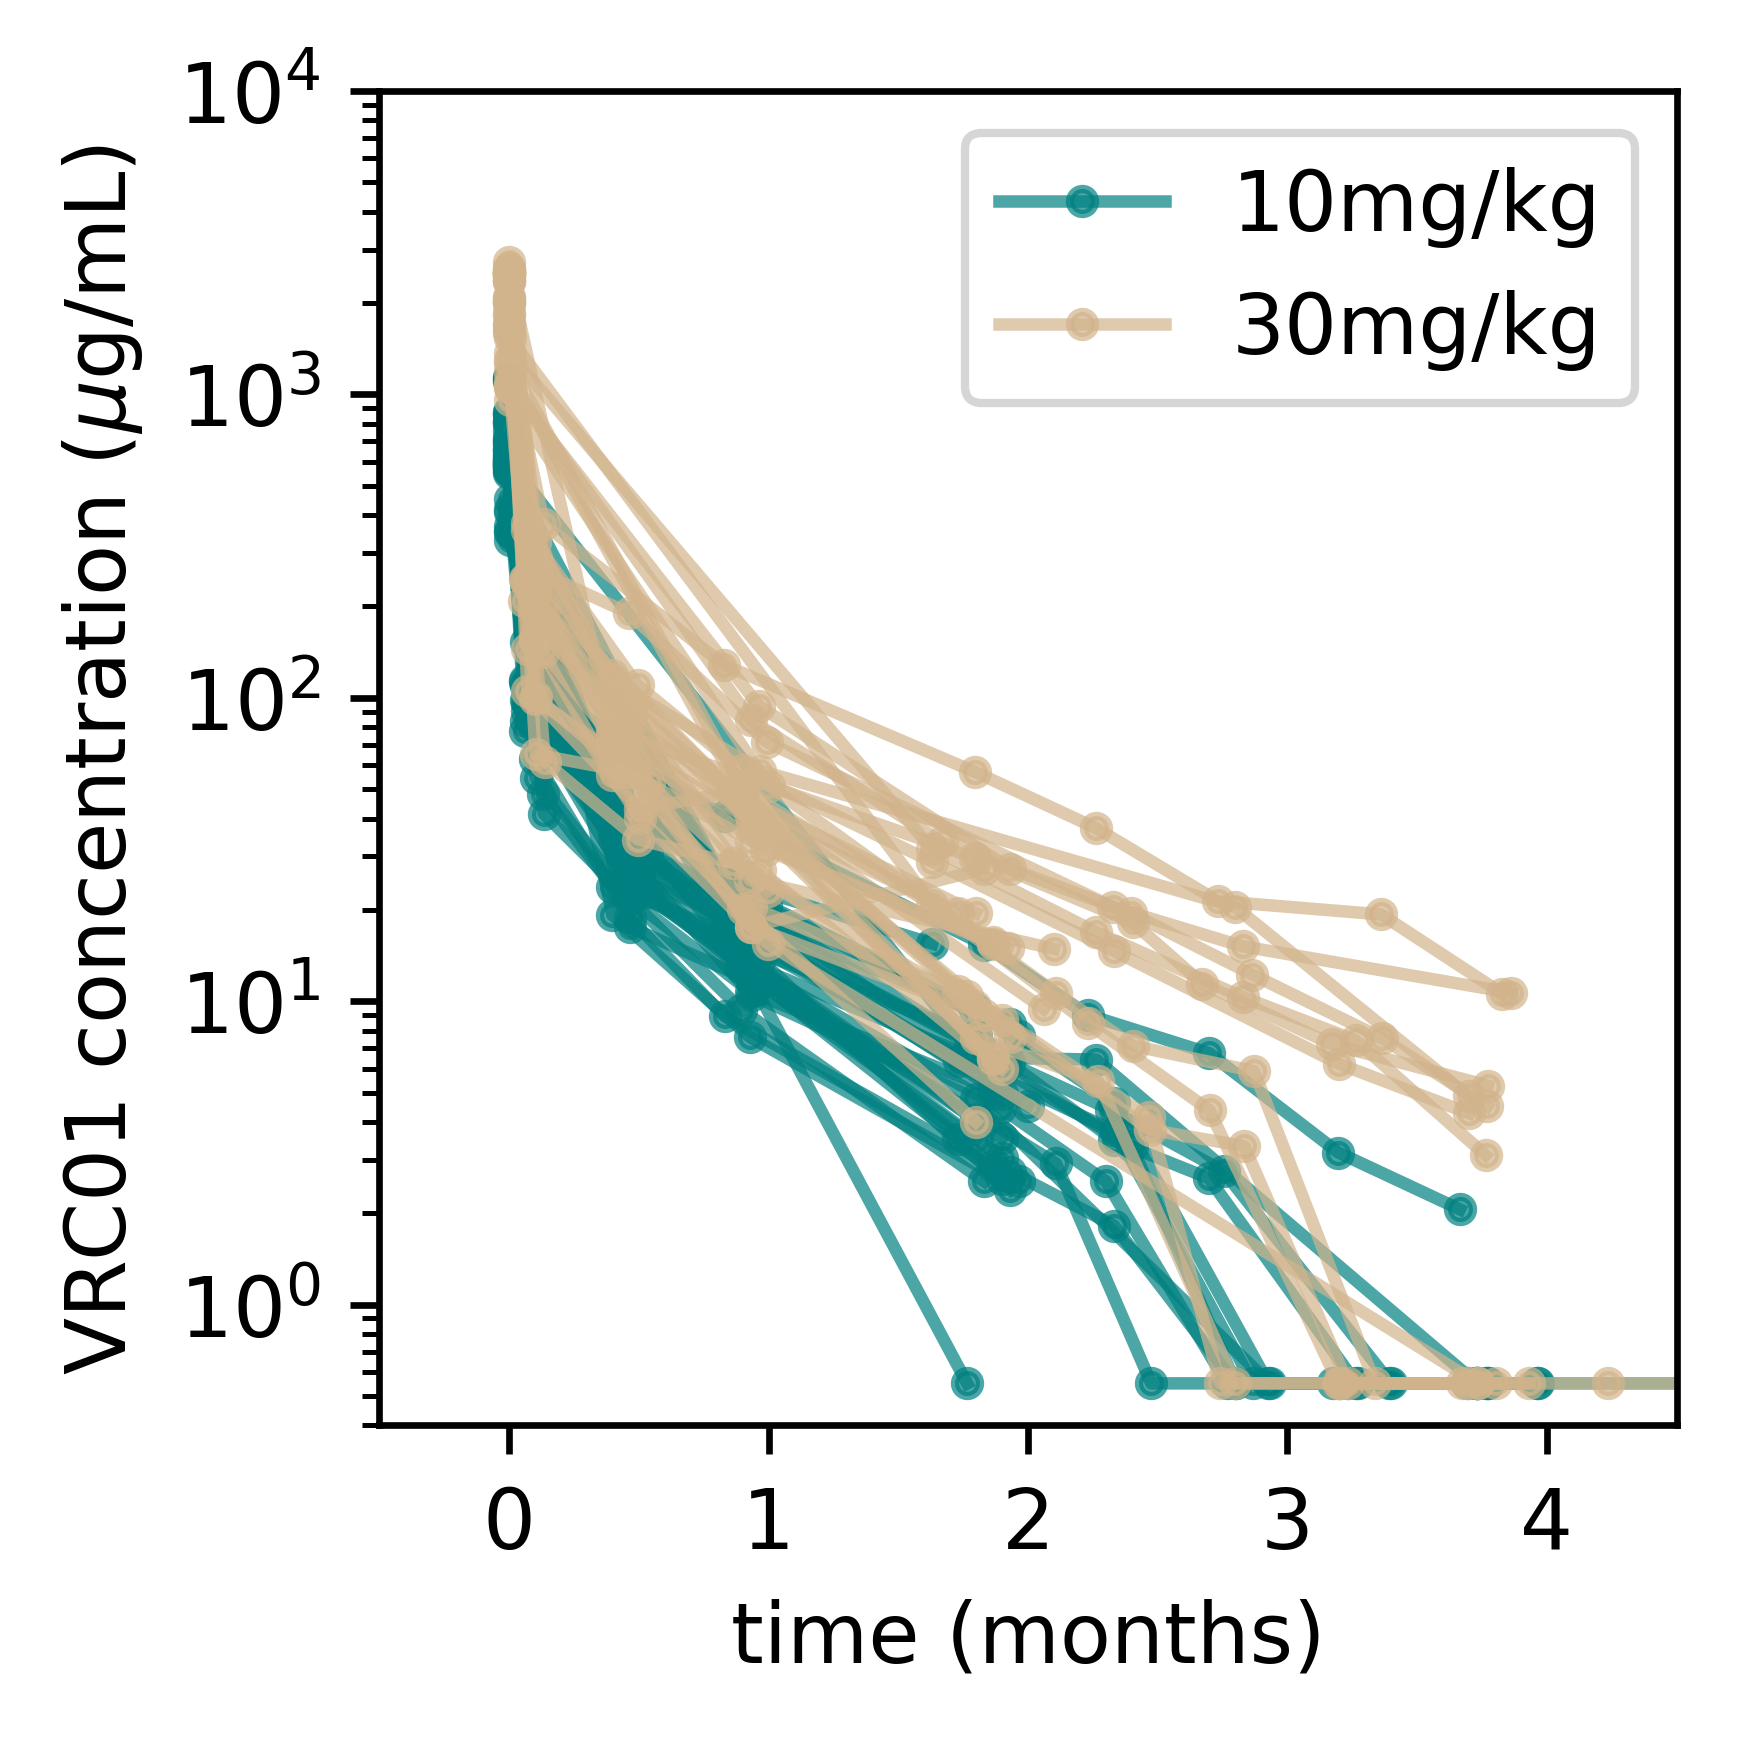

In [7]:
plt.figure(figsize=(3,3),dpi=rez)

#fit to each individual
PK_params=[[],[]] #list for optimal parameters 
l_list=[]
for i in range(len(cohort_names)):        
    #ax=axarr[i]
    for j in range(len(tt[i])):
        if len(dd[i][j])>3: #make sure 4 data points for 4 free params!
            tfit=np.array(tt[i][j])-tt[i][j][0] #zero out
            pb0=dd[i][j][0],0.5,1e2,0.01 #initial guess of parameters
            pboundz=((0,0,0,0),(np.infty,5,np.infty,1))
            l,=plt.semilogy(tfit/30,dd[i][j],color=c_list[i],marker='.',alpha=0.7)

            #fit the PK data, use that the variance is in absolute units and related to concentration
            popt,pcov=opt.curve_fit(bi_exp_fit,tfit,dd[i][j],pb0,ftol=1e-10,gtol=1e-10,
                                    sigma=np.array(dd[i][j]),absolute_sigma=True,
                                    bounds=pboundz)

            PK_params[i].append(popt)
            
    l_list.append(l)
            
plt.ylim([0.4,1e4])
plt.xlim([-0.5,4.5])
plt.xlabel('time (months)')
plt.ylabel('VRC01 concentration ($\mu$g/mL)')
plt.legend(l_list,cohort_names)
plt.tight_layout()
plt.savefig('figures/PK-data.pdf')

In [8]:
#store the PK parameters
pd.DataFrame.to_csv(pd.DataFrame(PK_params[0]),'data/PK10.csv')
pd.DataFrame.to_csv(pd.DataFrame(PK_params[1]),'data/PK30.csv')

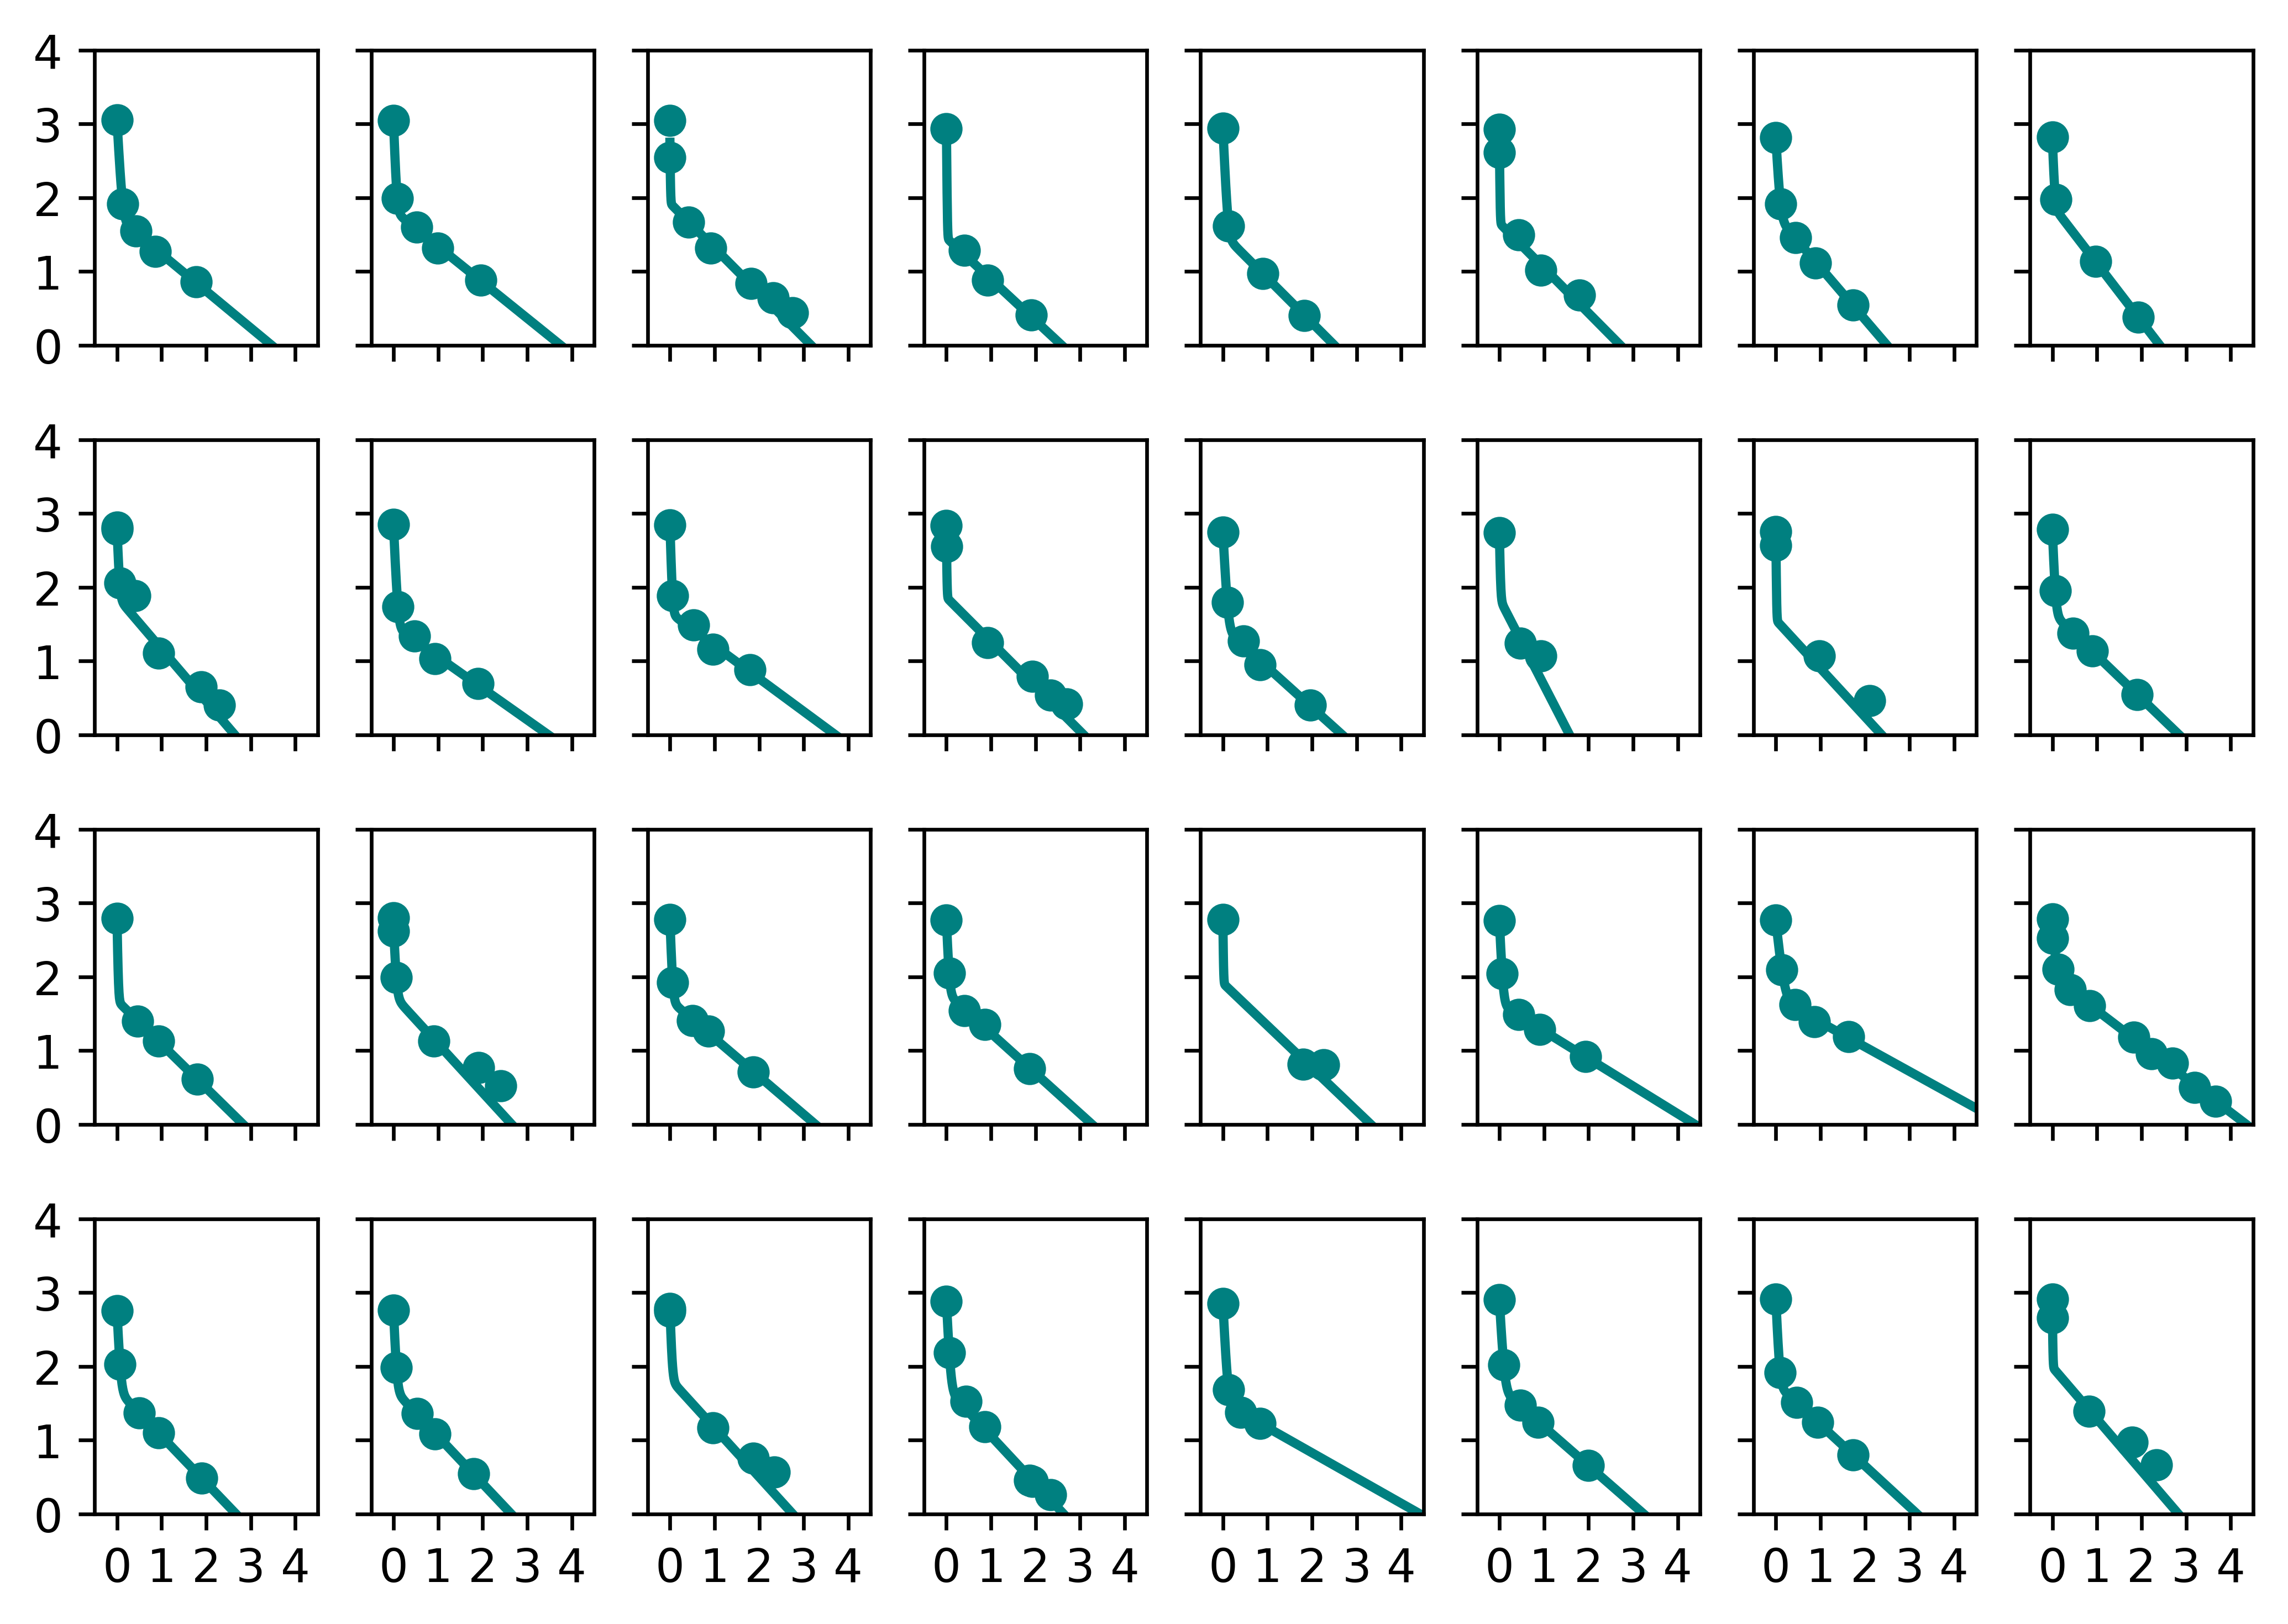

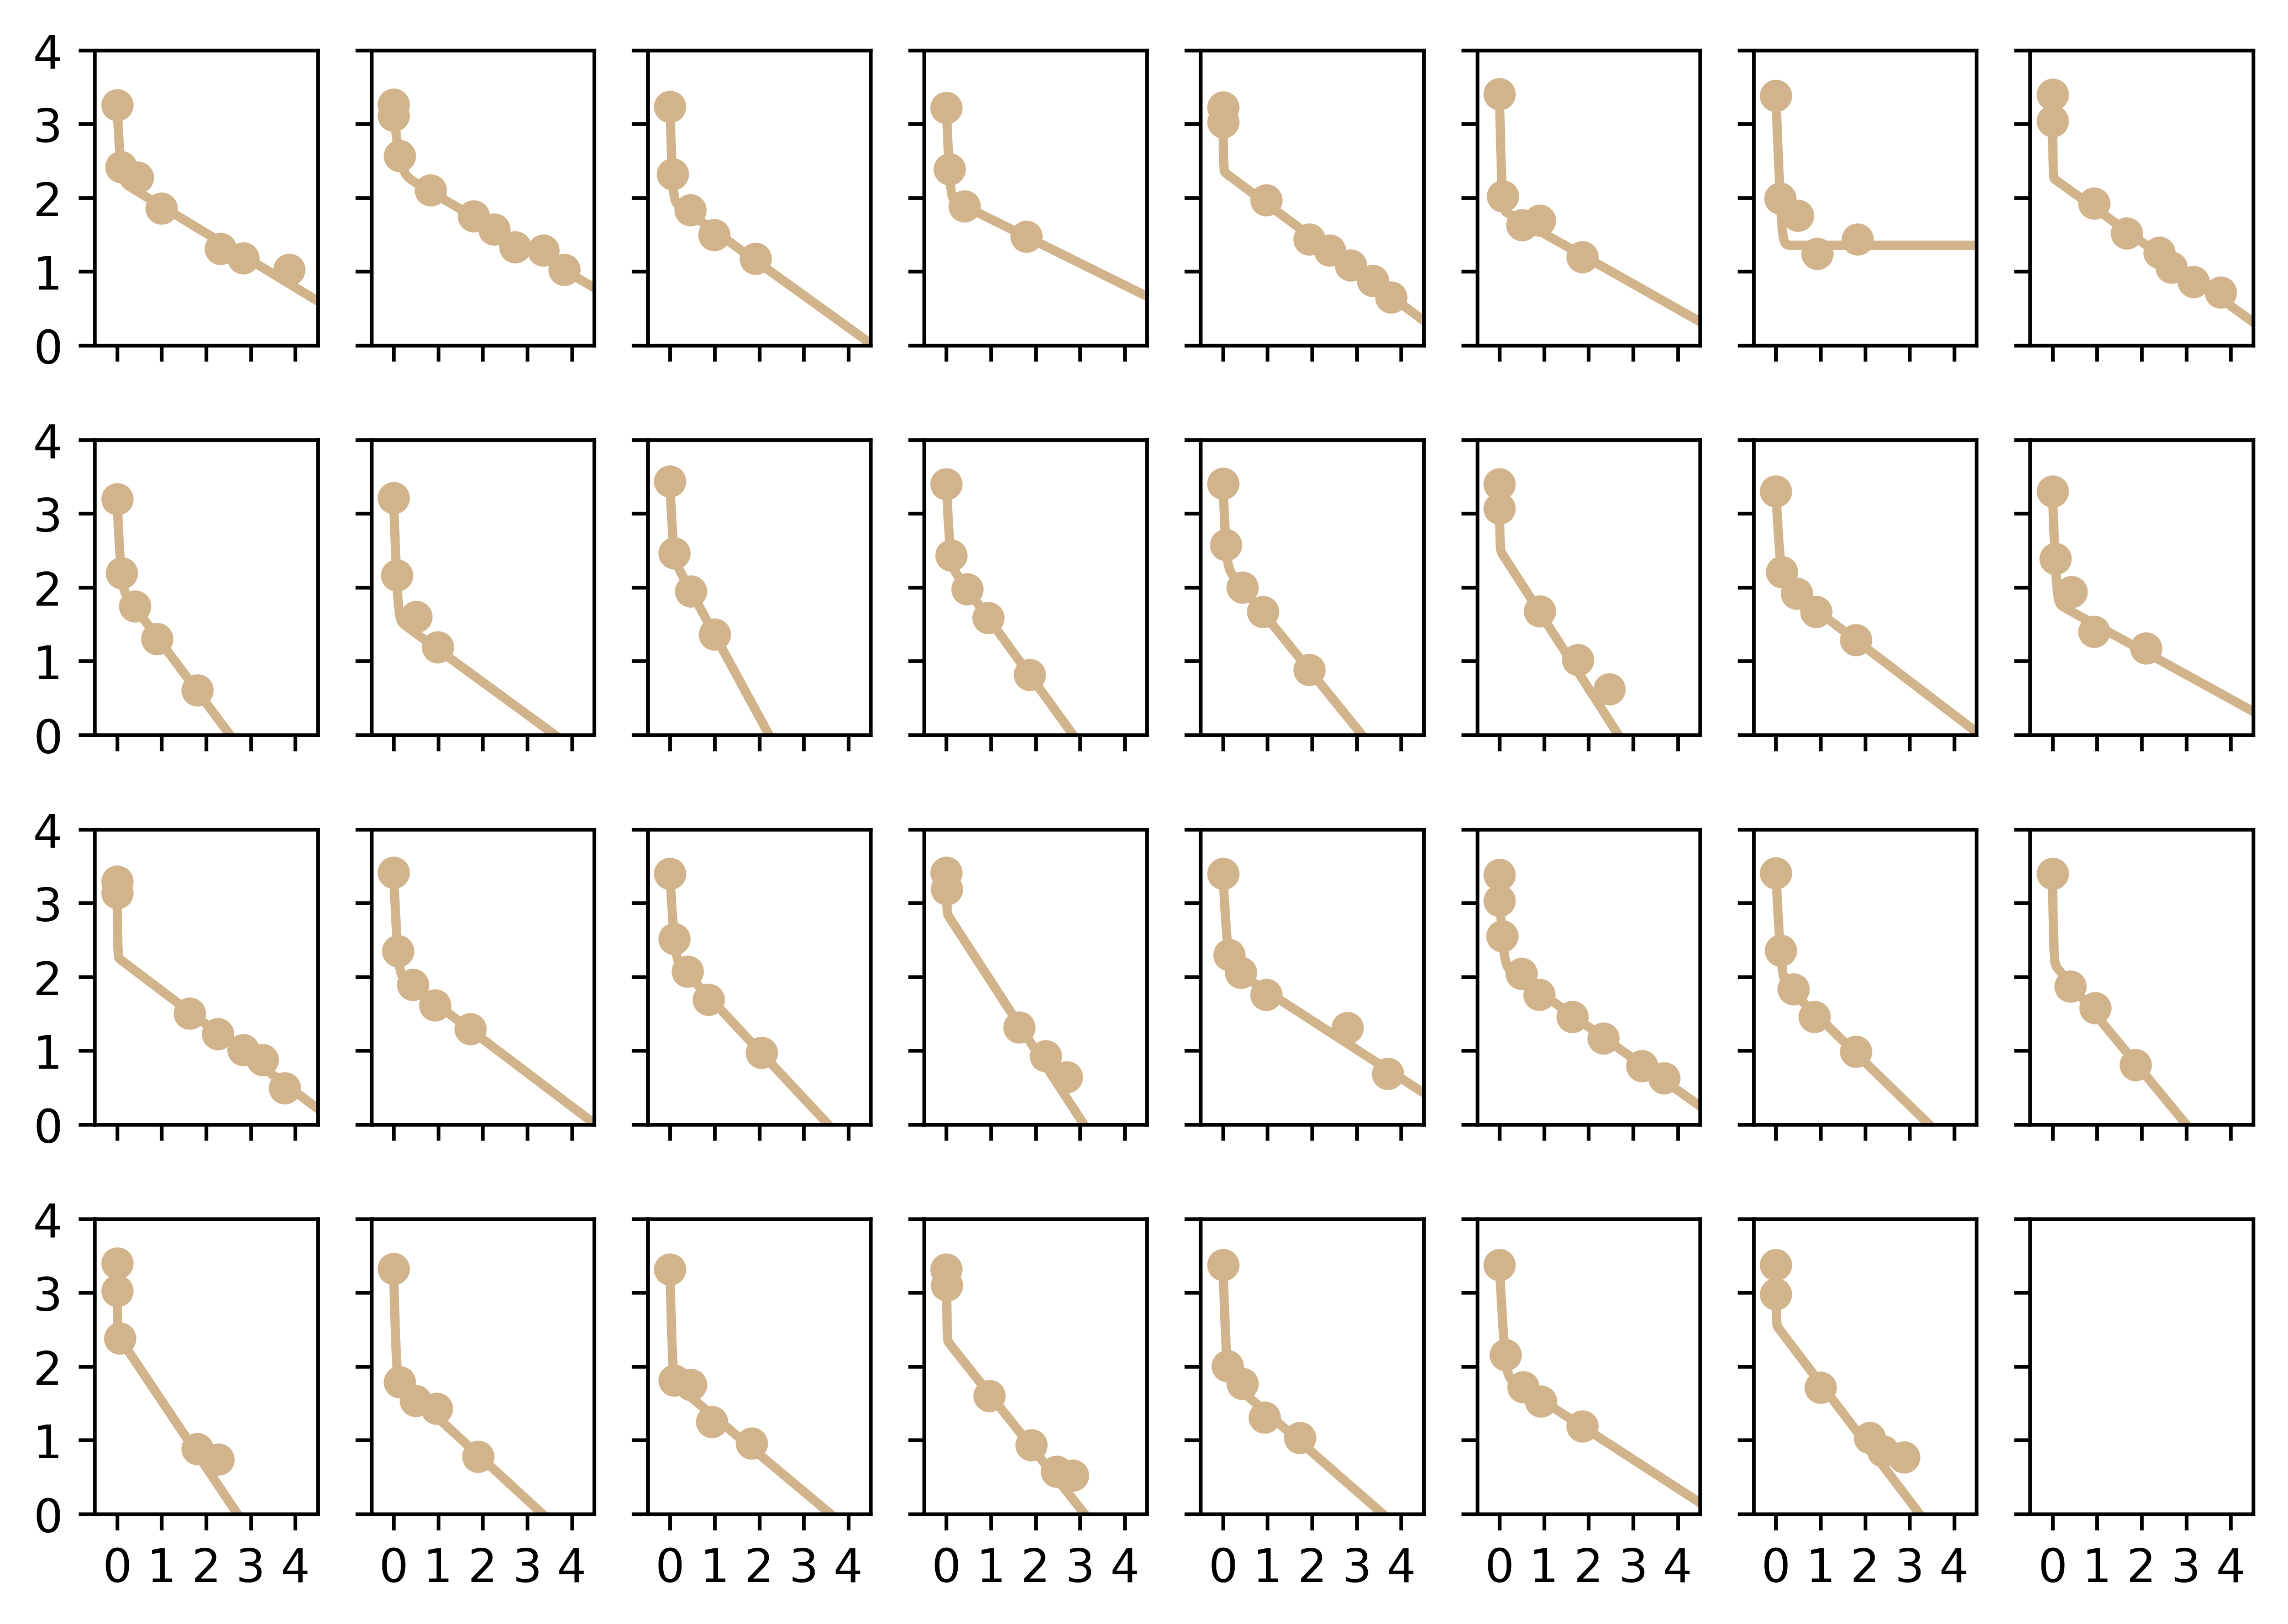

In [9]:
#plot all the fits! 

t_test=np.linspace(0,30*5,1e3)
for i in range(len(cohort_names)):        
    fig,axarr=plt.subplots(4,8,sharex=True,sharey=True,figsize=(7,5),dpi=rez)
    for j in range(len(tt[i])):
        if len(dd[i][j])>3: #make sure 4 data points for 4 free params!
        
            ax=axarr[int(j/8)][j%8] #go through the 6x6
            
            #plot data
            tfit=np.array(tt[i][j])-tt[i][j][0] #zero out
            ax.scatter(tfit/30, np.log10(dd[i][j]),color=c_list[i])
            
            #simulate the optimal parameter set and plot fit
            Y1,k1,Y2,k2=PK_params[i][j]
            conc_test = bi_exp_fit(t_test,Y1,k1,Y2,k2)
            ax.plot(t_test/30,np.log10(conc_test),lw=2,color=c_list[i])

    ax.set_ylim([0,4])
    ax.set_xlim([-0.5,4.5])
    ax.set_yticks(range(5))
    ax.set_xticks(range(5))
    
    plt.tight_layout()
    plt.savefig('figures/PKfits'+cohort_names[i][:2]+'.pdf')

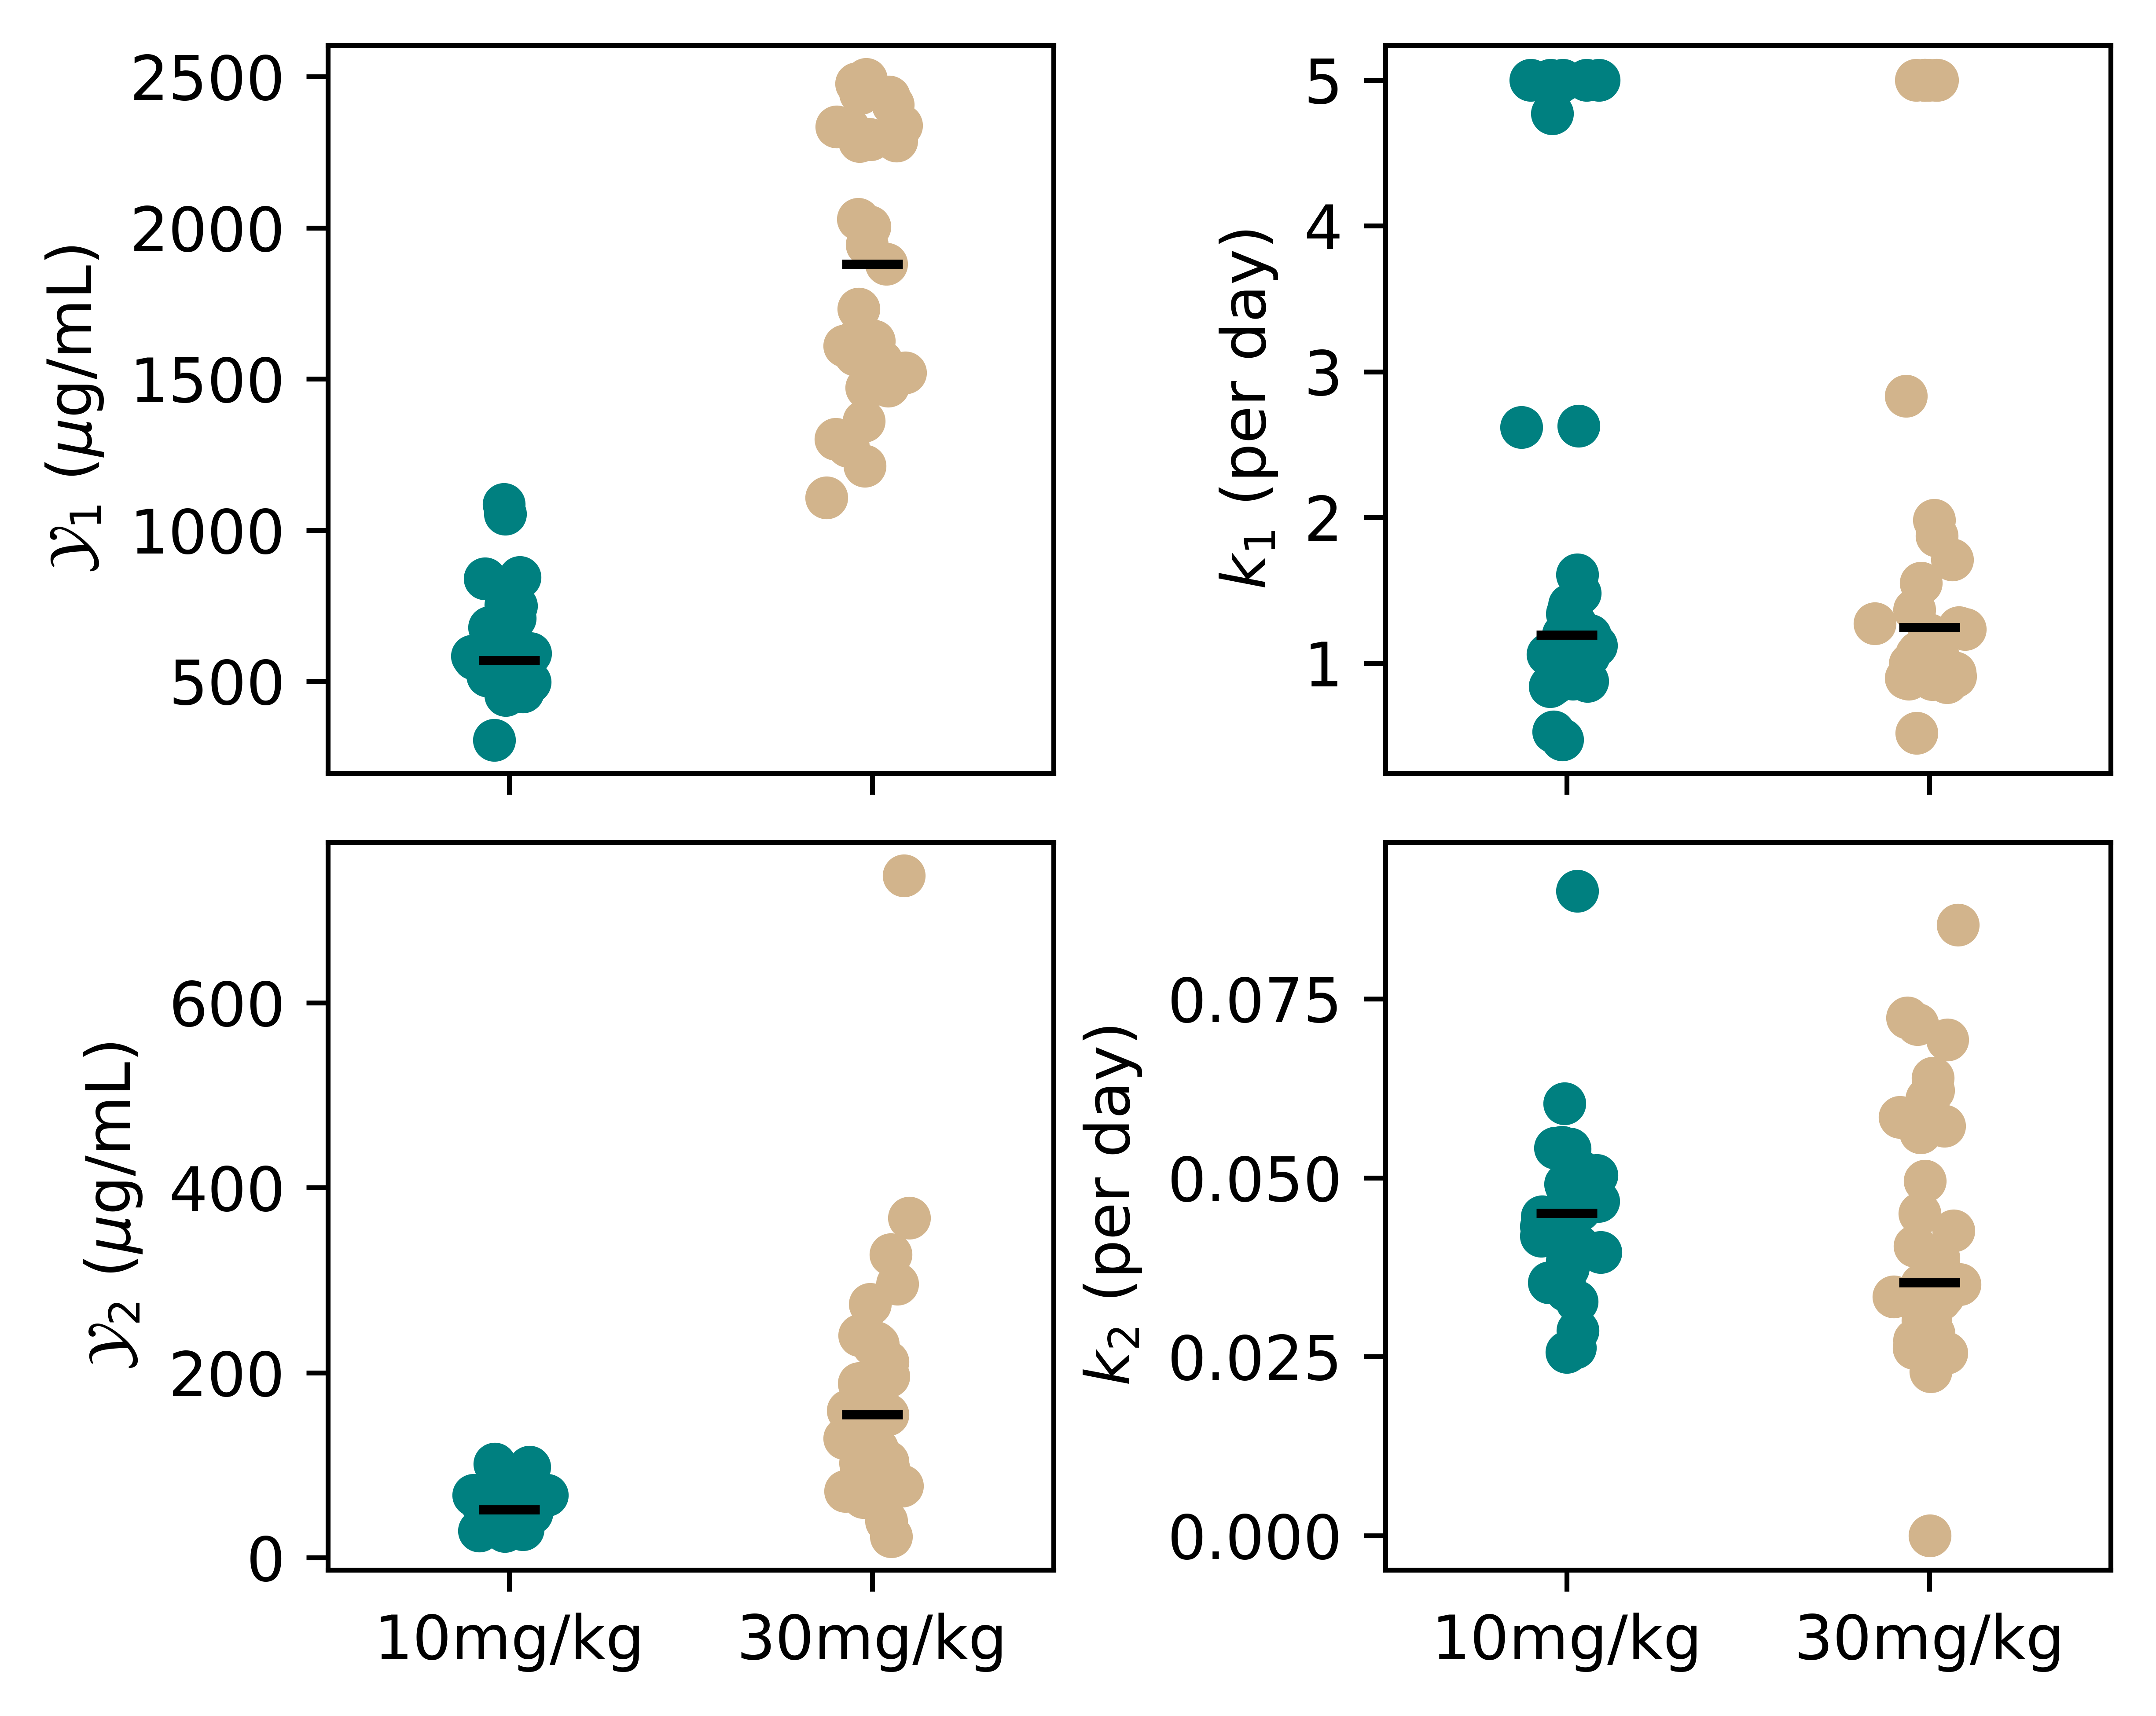

In [10]:
plt.figure(figsize=(5,4),dpi=1000)
param_names=['$\mathcal{Y}_1$ ($\mu$g/mL)','$k_1$ (per day)','$\mathcal{Y}_2$ ($\mu$g/mL)','$k_2$ (per day)']

for i in range(len(cohort_names)):        
    best_p = np.array(PK_params[i])        
    for j in range(len(param_names)):
        plt.subplot(221+j)
        plt.scatter(np.random.normal(i+1,0.05,len(best_p)),best_p[:,j],color=c_list[i])
        plt.scatter(i+1,np.median(best_p[:,j]),color='k',marker='_',s=100)

        plt.xlim([0.5,2.5])
        if j>1:
            plt.xticks([1,2],cohort_names)#,rotation=45)
        else:
            plt.xticks([1,2],[])#,rotation=45)

        plt.ylabel(param_names[j],fontsize=10)
        #plt.yscale('log')
        #plt.ylim([0,np.max(np.array(pp[j])[:,i])])
plt.tight_layout()
plt.savefig('figures/PKfits-paramvals.pdf')

In [11]:
#the sigmoidal curve logistic function that defines the pharmacodynamic response of VRC01
def PD_model(dose,IC50,h):
    res = 1/(1+(IC50/dose)**h)
    return res

In [12]:
#put in the subtypes

assay_data=assay[assay.Antibody=='VRC01'].dropna()

assay_data['subtype']='x' #set all to x subtype

in_v=0
for v in assay_data['Virus']:#.iloc[0:100]:
    subtype=viruses[viruses['Virus name']==v]['Subtype']
    #print(subtype.values[0])
    assay_data['subtype'].iloc[in_v]=subtype.values[0]
    in_v+=1

/Applications/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
#see how many subtypes there are
subtype_list = np.unique(assay_data['subtype'])

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in true_divide


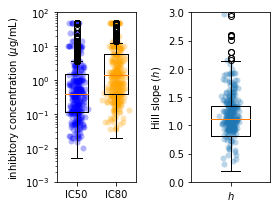

In [14]:
# IC50/80/h and dose response
jit=0.1 #for scatter jitter
plt.figure(figsize=(4,3))

#use smaller number for scatter
numic=300#len(assay_data.IC50)
dic50=np.array(assay_data.IC50)[:numic]
dic80=np.array(assay_data.IC80)[:numic]
h=-np.log(4)/np.log(dic50/dic80)

plt.subplot(121)
plt.scatter(np.random.normal(0,jit,[numic]),dic50,alpha=0.3,lw=0,color='blue')
plt.scatter(np.random.normal(1,jit,[numic]),dic80,alpha=0.3,lw=0,color='orange')
plt.subplot(122)
plt.scatter(np.random.normal(0,jit,[numic]),h,alpha=0.3,lw=0)

#now use all for boxplots
numic=len(assay_data.IC50)
dic50=np.array(assay_data.IC50)[:numic]
dic80=np.array(assay_data.IC80)[:numic]
h=-np.log(4)/np.log(dic50/dic80)

plt.subplot(121)
plt.boxplot([dic50,dic80],positions=[0,1],widths=0.6)
plt.yscale('log')
plt.xticks([0,1],['IC50','IC80'])
plt.ylabel('inhibitory concentration ($\mu$g/mL)')
plt.ylim([0.001,100])

plt.subplot(122)
plt.boxplot(h.tolist(),positions=[0],widths=1)
plt.ylabel('Hill slope ($h$)')
plt.xticks([0],['$h$'])
plt.xlim([-1,1])
plt.ylim([0,3])

plt.tight_layout()
plt.savefig('figures/PD-stats.pdf')  # No warning now



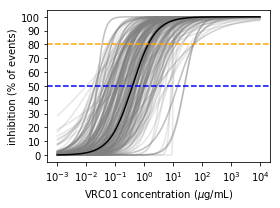

In [15]:
max_neut=100 #could allow for some strains that can never be neutralized?

plt.figure(figsize=(4,3))

dose=np.logspace(-3,4,1e3)
numdr=300;#len(assay_data.IC50) #number of dose response curves
for i in range(numdr):
    if h[i]>0:
        response=max_neut*(1/(1+(np.array(assay_data.IC50)[i]/dose)**h[i]))
        plt.semilogx(dose,response,color='gray',alpha=0.2)
medresponse=max_neut*(1/(1+(np.median(assay_data.IC50)/dose)**np.median(h)))

plt.plot(dose,medresponse,color='k')
plt.xlabel('VRC01 concentration ($\mu$g/mL)')
plt.ylabel('inhibition (% of events)')
plt.xticks([1e-3,1e-2,1e-1,1,10,100,1e3,1e4])
plt.yticks(range(0,101,10))
plt.axhline(50,ls='--',color='blue')
plt.axhline(80,ls='--',color='orange')
plt.minorticks_off()

plt.tight_layout()
plt.savefig('figures/PD-doseresponse.pdf')  # No warning now


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in true_divide
/Applications/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:1978: RuntimeWarning: invalid value encountered in double_scalars
  notch_max = med + 1.57 * iqr / np.sqrt(N)
/Applications/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3817: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/Applications/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:2058: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/Applications/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:2065: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/Applications/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:2073: RuntimeWarning: invalid value encountered in less
  np.compress(x 

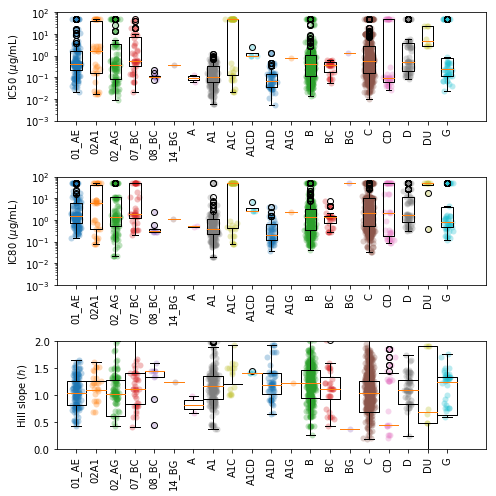

In [16]:
# IC50/80/h by subtype
plt.figure(figsize=(7,7))
#loop over all subtypes for scatters
for i in range(len(subtype_list)):

    ad_st = assay_data[assay_data['subtype']==subtype_list[i]]
    
    plt.subplot(311)
    plt.scatter(np.random.normal(i,jit,[len(ad_st.IC50)]),ad_st.IC50,alpha=0.3,lw=0)
    plt.boxplot(ad_st.IC50.values,positions=[i],widths=0.6)
    plt.yscale('log')
    plt.ylabel('IC50 ($\mu$g/mL)')
    plt.xlim([-1,len(subtype_list)+1])
    plt.ylim([0.001,100])
    plt.xticks(range(len(subtype_list)),subtype_list,rotation=90)
    
    plt.subplot(312)
    plt.scatter(np.random.normal(i,jit,[len(ad_st.IC80)]),ad_st.IC80,alpha=0.3,lw=0)
    plt.boxplot(ad_st.IC80.values,positions=[i],widths=0.6)
    plt.yscale('log')
    plt.ylabel('IC80 ($\mu$g/mL)')
    plt.xlim([-1,len(subtype_list)+1])
    plt.ylim([0.001,100])
    plt.xticks(range(len(subtype_list)),subtype_list,rotation=90)

    plt.subplot(313)
    h=-np.log(4)/np.log(ad_st.IC50.values/ad_st.IC80.values)
    plt.scatter(np.random.normal(i,jit,[len(ad_st.IC50)]),h,alpha=0.3,lw=0)
    plt.boxplot(h,positions=[i],widths=1)
    plt.ylabel('Hill slope ($h$)')
    plt.xticks(range(len(subtype_list)),subtype_list,rotation=90)
    plt.xlim([-1,len(subtype_list)+1])
    plt.ylim([0,2])

plt.tight_layout()
plt.savefig('figures/PDstats_subtype.pdf')  # No warning now


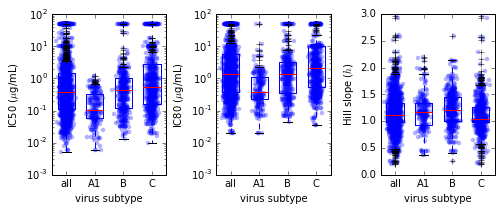

In [17]:
# clades ABC
plt.figure(figsize=(7,3),dpi=rez)

subtypes=['all','A1','B','C']

hl=[]; IC50l=[]; IC80l=[]

pind=0
for sb in subtypes:
    if sb=='all':
        ad=assay_data
    else:
        ad=assay_data[assay_data['subtype']==sb]

    IC50=np.array(ad.IC50)
    IC80=np.array(ad.IC80)
        
    #calculate hill slopes to rule out weird h<0
    h=-np.log(4)/np.log(IC50/IC80)

    #reset weird hill slopes
    h[h<0]=1
    hl.append(h)
    IC50l.append(IC50)
    IC80l.append(IC80)
    
    nx=len(h)
    
    #nx=sum(h>0)
    #clean the data set accordingly
    #hl.append(h[h>0])
    #IC50l.append(IC50[h>0])
    #IC80l.append(IC80[h>0])

    plt.subplot(131)
    plt.scatter(np.random.normal(pind,jit,[nx]),IC50l[pind],alpha=0.3,lw=0)

    plt.subplot(132)
    plt.scatter(np.random.normal(pind,jit,[nx]),IC80l[pind],alpha=0.3,lw=0)

    plt.subplot(133)
    plt.scatter(np.random.normal(pind,jit,[nx]),hl[pind],alpha=0.3,lw=0)

    #store the PD parameters by clade
    pd.DataFrame.to_csv(pd.DataFrame(np.transpose([IC50l[pind],hl[pind]])),'data/PD'+sb+'.csv')

    pind+=1

xx=tuple(np.arange(len(subtypes)))

plt.subplot(131)
plt.boxplot(IC50l,positions=xx,widths=0.6)
plt.yscale('log')
plt.xticks(xx,subtypes)
plt.ylabel('IC50 ($\mu$g/mL)')
plt.ylim([0.001,100])
plt.xlabel('virus subtype')
plt.xlim([-0.5,max(xx)+0.5])

plt.subplot(132)
plt.boxplot(IC80l,positions=xx,widths=0.6)
plt.yscale('log')
plt.xticks(xx,subtypes)
plt.ylabel('IC80 ($\mu$g/mL)')
plt.ylim([0.001,100])
plt.xlabel('virus subtype')
plt.xlim([-0.5,max(xx)+0.5])

plt.subplot(133)
plt.boxplot(hl,positions=xx,widths=0.6)
plt.ylabel('Hill slope ($h$)')
plt.xlabel('virus subtype')
plt.xticks(xx,subtypes)
#plt.xlim([-1,1])
plt.ylim([0,3])
plt.xlim([-0.5,max(xx)+0.5])

plt.tight_layout()
plt.savefig('figures/PDstats_ABC.pdf')  # No warning now


/Users/danielreeves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


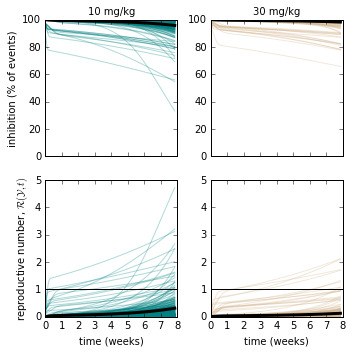

In [24]:
#theoretical curves drawing from all distributions
R0l=pd.DataFrame.from_csv('data/viral_dynamics.csv').iloc[:,0] #list from Robb fitting

num_curves=300
cladeind=1 #subtype, 0=>A1, 1=>B, 2=>C

#simulate inhibitions over time
t=np.linspace(0,55,1e3)
fig,axarr=plt.subplots(2,2,sharex=True,dpi=rez,figsize=(5,5))

#loop over 2 doses
for i in [0,1]:        
    rrl=[]; Rtl=[]
    #loop over number of PKPD curves
    for k in range(num_curves):
        
        randPKind=np.random.randint(0,len(PK_params[i])) #random PK index
        randPDind=np.random.randint(0,len(IC50l[cladeind])) #random PD index
        randR0ind=np.random.randint(0,len(R0l)) #random R0 index
        
        Y1,k1,Y2,k2=PK_params[i][randPKind][0:4] #pk values from list
        pk=bi_exp_fit(t,Y1,k1,Y2,k2) #simulate the pk fit
        
        rresponse=1/(1+(IC50l[cladeind][randPDind]/pk)**hl[cladeind][randPDind]) #inhibition over time

        R0=R0l[randR0ind]; #draw from a distribution or the Robb data
        
        axarr[0][i].plot(t/7,max_neut*rresponse,color=c_list[i],alpha=0.3,ls='-')
        axarr[1][i].plot(t/7,R0*(1-rresponse),color=c_list[i],alpha=0.3,ls='-')

        rrl.append(max_neut*rresponse)
        Rtl.append(R0*(1-rresponse))

    #calculate means and plot
    mrrl=np.mean(rrl,0)
    mRtl=np.mean(Rtl,0)
    axarr[0][i].plot(t/7,mrrl,color='k',lw=3,ls='-')
    axarr[1][i].plot(t/7,mRtl,color='k',lw=3,ls='-')
      
axarr[0][0].set_title('10 mg/kg',fontsize=10)
axarr[0][1].set_title('30 mg/kg',fontsize=10)
axarr[0][0].set_ylabel('inhibition (% of events)')
axarr[1][0].set_ylabel(r'reproductive number, $\mathcal{R}(\mathcal{Y},t)$')#,fontsize=13)
axarr[0][0].set_xticks(range(9))

axarr[0][0].set_ylim([0,100])
axarr[0][1].set_ylim([0,100])
axarr[1][0].set_ylim([0,5])
axarr[1][1].set_ylim([0,5])

for j in range(2):
    axarr[1][j].set_xlabel('time (weeks)')
    axarr[1][j].axhline(1,color='k',lw=1)

plt.tight_layout()
plt.savefig('figures/inhibition_R0.pdf')  # No warning now



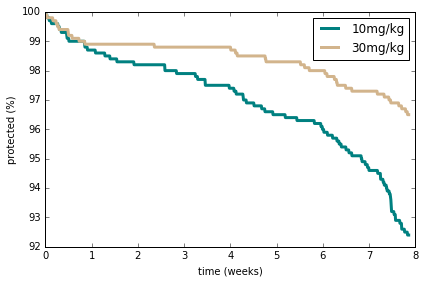

In [43]:
num_curves=1000

#loop over 2 doses
for i in [0,1]:        
    rrl=[]; Rtl=[]
    #loop over number of PKPD curves
    for k in range(num_curves):
        
        randPKind=np.random.randint(0,len(PK_params[i])) #random PK index
        randPDind=np.random.randint(0,len(IC50l[cladeind])) #random PD index
        randR0ind=np.random.randint(0,len(R0l)) #random R0 index
        
        Y1,k1,Y2,k2=PK_params[i][randPKind][0:4] #pk values from list
        pk=bi_exp_fit(t,Y1,k1,Y2,k2) #simulate the pk fit
        
        rresponse=1/(1+(IC50l[cladeind][randPDind]/pk)**hl[cladeind][randPDind]) #inhibition over time

        R0=R0l[randR0ind]; #draw from a distribution or the Robb data
        
        axarr[0][i].plot(t/7,max_neut*rresponse,color=c_list[i],alpha=0.3,ls='-')
        axarr[1][i].plot(t/7,R0*(1-rresponse),color=c_list[i],alpha=0.3,ls='-')

        Rtl.append(R0*(1-rresponse))

    plt.plot(t/7,(1-np.sum(np.array(Rtl)>1,0)/num_curves)*100,color=c_list[i],lw=3)
    plt.xlabel('time (weeks)')
    plt.ylabel('protected (%)')
plt.legend(['10mg/kg','30mg/kg'])
plt.tight_layout()
plt.savefig('figures/protectedpct.pdf')  # No warning now
